In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from datetime import datetime 
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from tensorflow.keras.models import Model
#from keras.layers import Conv2D
import os
from tensorflow.keras.applications.vgg16 import VGG16

#XGBOOST
import xgboost as xgb

In [50]:
file_dir = "D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/"

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 512 #Resize images (height  = X, width = Y)
SIZE_Y = 512

#Capture training image info as a list
train_images = []

for img_path in glob.glob(os.path.join(file_dir,"train", "*.png")):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
    #train_labels.append(label)
    
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for mask_path in glob.glob(os.path.join(file_dir,"train_mask", "*.png")):
    mask = cv2.imread(mask_path, 0)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    mask[mask > 0] = 255
    #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    train_masks.append(mask)
    #train_labels.append(label)
    
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [51]:
#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 
y_train.shape

(90, 512, 512, 1)

In [52]:
np.save("D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/feature/y_train.npy",y_train)

In [6]:
SIZE_X = 512 #Resize images (height  = X, width = Y)
SIZE_Y = 512

#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [7]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [53]:
new_x_train = np.array_split(X_train,3)
new_x_train[0].shape

(30, 512, 512, 3)

In [54]:
for i in range (len(new_x_train)):
    features=new_model.predict(new_x_train[i])
    feature_dir = os.path.join(file_dir, 'feature')
    if not os.path.exists(feature_dir):
        os.makedirs(feature_dir)
    feature_file = os.path.join(feature_dir,'feature'+str(i)+'.npy')
    np.save(feature_file,features)


In [55]:
feat1 = np.load("D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/feature/feature0.npy")
feat2 = np.load("D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/feature/feature1.npy")
feat3 = np.load("D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/feature/feature2.npy")
X = np.concatenate((feat1,feat2,feat3),axis=0)
X.shape

(90, 512, 512, 64)

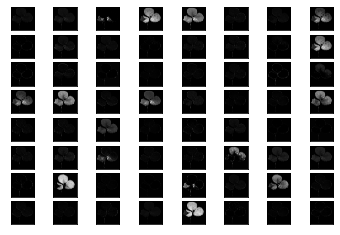

In [56]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(X[1,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()


In [57]:
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)


In [58]:
#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset.head(5)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.0,0.649344,0.942782,4.632154,0.0,0.337238,0.049251,0.0,1.053239,...,0.03788,0.898025,1.449590,0.258110,0.000000,1.080628,2.011198,0.640442,0.298698,1.533249
1,0.389087,0.0,0.952366,1.431777,6.962410,0.0,0.000000,0.131221,0.0,1.404921,...,0.00000,2.003761,2.884965,0.222496,0.423538,1.661503,2.963066,1.372328,0.817445,1.891306
2,0.389087,0.0,0.952366,1.431777,6.962410,0.0,0.000000,0.131221,0.0,1.404921,...,0.00000,2.003761,2.884965,0.222496,0.423538,1.661503,2.963066,1.372328,0.817445,1.891306
3,0.389087,0.0,0.952366,1.431777,6.962410,0.0,0.000000,0.131221,0.0,1.404921,...,0.00000,2.003761,2.884965,0.222496,0.423538,1.661503,2.963066,1.372328,0.817445,1.891306
4,0.389087,0.0,0.952366,1.431777,6.962410,0.0,0.000000,0.131221,0.0,1.404921,...,0.00000,2.003761,2.884965,0.222496,0.423538,1.661503,2.963066,1.372328,0.817445,1.891306


In [59]:
# normalizing features
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()
dataset = mc.fit_transform(dataset)
dataset = pd.DataFrame(dataset)


In [60]:
# adding training y
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())
dataset.head()


[  0 255]
0      22764707
255      828253
Name: Label, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,Label
0,0.000000,0.0,0.000830,0.000671,0.002051,0.0,0.00013,0.000041,0.0,0.001130,...,0.000353,0.000631,0.000148,0.00000,0.000474,0.001667,0.000707,0.000114,0.000894,0
1,0.000154,0.0,0.001217,0.001019,0.003083,0.0,0.00000,0.000110,0.0,0.001507,...,0.000787,0.001255,0.000127,0.00015,0.000729,0.002456,0.001515,0.000312,0.001103,0
2,0.000154,0.0,0.001217,0.001019,0.003083,0.0,0.00000,0.000110,0.0,0.001507,...,0.000787,0.001255,0.000127,0.00015,0.000729,0.002456,0.001515,0.000312,0.001103,0
3,0.000154,0.0,0.001217,0.001019,0.003083,0.0,0.00000,0.000110,0.0,0.001507,...,0.000787,0.001255,0.000127,0.00015,0.000729,0.002456,0.001515,0.000312,0.001103,0
4,0.000154,0.0,0.001217,0.001019,0.003083,0.0,0.00000,0.000110,0.0,0.001507,...,0.000787,0.001255,0.000127,0.00015,0.000729,0.002456,0.001515,0.000312,0.001103,0


In [61]:
#Redefine X and Y 
x = dataset.drop(labels = ['Label'], axis=1)
x = x.values  #Convert to array
y = dataset['Label']
y = y.values  #Convert to array


In [ ]:
########################
#Load validation image and prepare it for prediction
# validation_img = cv2.imread('images/test_images/test1_img.tif', cv2.IMREAD_COLOR)       
# validation_img = cv2.resize(validation_img, (SIZE_Y, SIZE_X))
# validation_img = cv2.cvtColor(validation_img, cv2.COLOR_RGB2BGR)
# validation_img = np.expand_dims(validation_img, axis=0)
#Capture validation image info as a list
val_images = []

for img_path in glob.glob(os.path.join(file_dir,"test", "*.png")):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    val_images.append(img)
    #train_labels.append(label)
    
#Convert list to array for machine learning processing        
val_images = np.array(val_images)



In [ ]:
X_validation_feature = new_model.predict(val_images)
X_validation_feature = X_validation_feature.reshape(-1, X_validation_feature.shape[3])


In [ ]:
np.save("D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf1/features/val_features.npy",X_validation_feature)

In [ ]:
#Load corresponding ground truth image (Mask) and reshape it for comparison with prediction
truth = []

for mask_path in glob.glob(os.path.join(file_dir,"test/imgAno", "*.png")):
    mask = cv2.imread(mask_path, 0)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    truth.append(mask)
    #train_labels.append(label)
    
#Convert list to array for machine learning processing          
truth = np.array(truth) 
truth.reshape(-1)
truth.shape

In [62]:
xgb_model = xgb.XGBClassifier()

# Y_for_training = Y_for_training-1 

start = datetime.now() 
# Train the model on training data
xgb_model.fit(x, y) 
stop = datetime.now()

#Execution time of the model 
execution_time_xgb = stop-start 
print("XGBoost execution time is: ", execution_time_xgb)


C:\Users\USER\.conda\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost execution time is:  0:46:44.373406


In [63]:
#Save model for future use
filename = 'D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/model_XG.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

filename_json = 'D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/model_XG.json'
xgb_model.save_model(filename_json)


In [ ]:
# Load xgb model
xgb_model = xgb.XGBClassifier()

filename = 'D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf1/model_XG.sav'

xgb_model = pickle.load(open(filename, "rb"))

In [27]:
#Load validation image and prepare it for prediction
validation_img = cv2.imread('D:/Anil/Dataset/gray_mold/val/val_img_0.png', cv2.IMREAD_COLOR)       
validation_img = cv2.resize(validation_img, (SIZE_Y, SIZE_X))
validation_img = cv2.cvtColor(validation_img, cv2.COLOR_RGB2BGR)
val_img = validation_img
validation_img = np.expand_dims(validation_img, axis=0)


In [28]:
X_validation_feature = new_model.predict(validation_img)

X_validation_feature = X_validation_feature.reshape(-1, X_validation_feature.shape[3])
X_validation_feature.shape


(262144, 64)

In [29]:
#Load corresponding ground truth image (Mask) and reshape it for comparison with prediction
truth = cv2.imread('D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf1/test/imgAno/img_26.png', 0)
truth[truth > 0] = 255
GT = truth.reshape(-1)
GT.shape

(262144,)

In [30]:
# normalizing test data
# normalizing features
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()

X_validation_feature = mc.fit_transform(X_validation_feature)


In [34]:
X_validation_feature.shape

(262144, 64)

In [31]:
prediction_xgb = xgb_model.predict(X_validation_feature)


In [32]:
predict_img = prediction_xgb.reshape((512,512))
predict_img.shape

(512, 512)

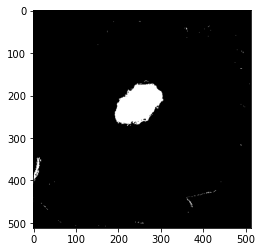

In [33]:
plt.imshow(predict_img,cmap = 'gray')
plt.show()

In [ ]:
pred_path = 'D:/Anil/Dataset/gray_mold/pred_test3.jpg'
cv2.imwrite(pred_path,predict_img)


In [ ]:
plt.imshow(truth,cmap='gray')
plt.show()


In [ ]:
#Pixel accuracy - not a good metric for semantic segmentation
#Print overall accuracy

print ("Accuracy = ", metrics.accuracy_score(GT, prediction_xgb))


In [ ]:
from tensorflow.keras.metrics import MeanIoU
num_classes = 2
iou = MeanIoU(num_classes=num_classes)
iou.update_state(GT/255,prediction_xgb/255)
iou.result().numpy()


In [ ]:
np.unique(prediction_xgb)

In [ ]:
plt.imshow(predict_img, cmap='gray')

In [ ]:
plt.imshow(val_img)

In [ ]:
# IoU accuracy calculation
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3]) # this is for model training
#     union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#     intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3]) # this is for model training
#     union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,axis=-1)+K.sum(y_pred,axis=-1)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# Dice accuracy calculation
def dice_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#     union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [ ]:
iou = iou_coef(truth_img/255.0,predict_img/255.0)
print(iou)

In [ ]:
truth_img = cv2.imread('D:/Anil/Dataset/gray_mold/val/GT/val_img_0.png',0)
# truth_img.reshape((1,512,512,1))
# truth_img = np.expand_dims(truth_img, axis=0)
# truth_img.shape

In [ ]:
truth_img

In [ ]:
predict_img

In [ ]:
val1 = np.arange(24).reshape((4, 6))
y_true = K.variable(value=val1)

val2 = np.arange(10,34).reshape((4, 6))
y_pred = K.variable(value=val2)

In [ ]:
result = K.eval(iou_coef(y_true=truth_img/255.0, y_pred=predict_img/255.0))
print('result is:', result)

In [ ]:
result = K.eval(dice_coef(y_true=truth_img/255.0, y_pred=predict_img/255.0))
print('result is:', result)

In [ ]:
# calculating IoU and dice accuracy of trained model
file_path = "D:/Anil/Dataset/gray_mold/val/"
gt_path = "D:/Anil/Dataset/gray_mold/val/GT/"
val_imgs = []
val_gt = []
for f in glob.glob(os.path.join(file_path,'*.png')):
    img = cv2.imread()
    val_imgs.append(f)
    
# Ground truth image array
for f in glob.glob(os.path.join(gt_path,'*.png')):
    val_gt.append(f)
val_gt[10]

In [ ]:
#Load validation image and prepare it for prediction
validation_img = cv2.imread('D:/Anil/Dataset/gray_mold/val/val_img_0.png', cv2.IMREAD_COLOR)       
validation_img = cv2.resize(validation_img, (SIZE_Y, SIZE_X))
validation_img = cv2.cvtColor(validation_img, cv2.COLOR_RGB2BGR)
val_img = validation_img
validation_img = np.expand_dims(validation_img, axis=0)


In [ ]:
X_validation_feature = new_model.predict(validation_img)
X_validation_feature = X_validation_feature.reshape(-1, X_validation_feature.shape[3])

In [ ]:
# normalizing test data
X_validation_feature = mc.fit_transform(X_validation_feature)
prediction_xgb = xgb_model.predict(X_validation_feature)
predict_img = prediction_xgb.reshape(truth.shape)
plt.imshow(predict_img, cmap='gray')


In [ ]:
#Load corresponding ground truth image (Mask) and reshape it for comparison with prediction
truth = cv2.imread('D:/Anil/Dataset/gray_mold/val/GT/val_img_0.png', 0)
GT = truth.reshape(-1)

#Print overall accuracy

print ("Accuracy = ", metrics.accuracy_score(GT, prediction_xgb))


In [ ]:
num_classes = 2
iou = MeanIoU(num_classes=num_classes)
iou.update_state(truth_img/255,predict_img/255)
iou.result().numpy()


In [ ]:
intersect = np.logical_and(GT,prediction_xgb)
union = np.logical_or(GT,prediction_xgb)
iou_score = np.sum(intersect)/np.sum(union)
print(iou_score)

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "D:/Anil/Dataset/gray_mold/img_69.PNG"
img = image.load_img(img_path, target_size=(512, 512))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [ ]:
layer_outputs = [layer.output for layer in VGG_model.layers[:2]] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=VGG_model.input, outputs=layer_outputs) # Creates a model

In [ ]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
# Visualizing every channel in every intermediate activation
layer_names = []
for layer in VGG_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')